In [14]:
## build an autoencoder model for topic categorization
# input is already equal length vectors, no need to use LSTM..., will use dense layers + non-linear activations
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
class aet(nn.Module):
    def __init__(self,input_dim,hd1,hd2,hd3,hd4,drop):
        super().__init__()
        self.dropout = nn.Dropout(drop)
        self.h1 = nn.Linear(input_dim, hd1)
        self.h2 = nn.Linear(hd1,hd2)
        self.h3 = nn.Linear(hd2,hd3)
        self.h4 = nn.Linear(hd3,hd4)
        self.outl = nn.Linear(hd4,input_dim)
    def forward(self,texts):
        h1v = self.dropout(self.h1(texts))
        h2v = F.relu(self.h2(h1v))
        h3v = torch.tanh(self.h3(h2v))
        h4v = F.relu(self.h4(h3v))
        hout = self.outl(h4v)
        return hout, h3v

In [3]:
import pickle
emb0 = pickle.load(open('emb_HN.p','rb'))

In [4]:
emb = emb0[1:]

In [5]:
emb = torch.as_tensor(emb, dtype=torch.float32)

In [6]:
input_dim = emb.shape[1]

In [7]:
hd1 = 300
hd2 = 100
hd3 = 15
hd4 = 200
drop = 0.2

device = 'cuda'

In [8]:
model0 = aet(input_dim,hd1,hd2,hd3,hd4,drop)

In [9]:
model0.to(device)

aet(
  (dropout): Dropout(p=0.2, inplace=False)
  (h1): Linear(in_features=768, out_features=300, bias=True)
  (h2): Linear(in_features=300, out_features=100, bias=True)
  (h3): Linear(in_features=100, out_features=15, bias=True)
  (h4): Linear(in_features=15, out_features=200, bias=True)
  (outl): Linear(in_features=200, out_features=768, bias=True)
)

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model0.parameters())

In [11]:
trainiter = DataLoader(emb, batch_size=2048, shuffle=True)

In [12]:
def training(model, criterion, optimizer, trainiter, device):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trainiter):
        tin = batch.to(device)
        optimizer.zero_grad()
        recons,_ = model(tin)
        loss = criterion(recons, tin)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()
        
        #print(f'Batch：{i+1} | Loss: {loss.item()}')
    return epoch_loss/len(trainiter)

In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
import time, math

In [15]:
N_EPOCHS = 20
CLIP = 1

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = training(model0, criterion, optimizer, trainiter, device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.7f} | Train PPL: {math.exp(train_loss):7.3f}')

Epoch: 01 | Time: 0m 12s
	Train Loss: 0.0156139 | Train PPL:   1.016
Epoch: 02 | Time: 0m 12s
	Train Loss: 0.0079720 | Train PPL:   1.008
Epoch: 03 | Time: 0m 12s
	Train Loss: 0.0073643 | Train PPL:   1.007
Epoch: 04 | Time: 0m 12s
	Train Loss: 0.0070929 | Train PPL:   1.007
Epoch: 05 | Time: 0m 12s
	Train Loss: 0.0069374 | Train PPL:   1.007
Epoch: 06 | Time: 0m 11s
	Train Loss: 0.0067898 | Train PPL:   1.007
Epoch: 07 | Time: 0m 12s
	Train Loss: 0.0066932 | Train PPL:   1.007
Epoch: 08 | Time: 0m 12s
	Train Loss: 0.0066347 | Train PPL:   1.007
Epoch: 09 | Time: 0m 11s
	Train Loss: 0.0065953 | Train PPL:   1.007
Epoch: 10 | Time: 0m 12s
	Train Loss: 0.0065600 | Train PPL:   1.007
Epoch: 11 | Time: 0m 12s
	Train Loss: 0.0065210 | Train PPL:   1.007
Epoch: 12 | Time: 0m 11s
	Train Loss: 0.0064851 | Train PPL:   1.007
Epoch: 13 | Time: 0m 11s
	Train Loss: 0.0064521 | Train PPL:   1.006
Epoch: 14 | Time: 0m 11s
	Train Loss: 0.0064251 | Train PPL:   1.006
Epoch: 15 | Time: 0m 12s
	Train Lo

In [16]:
torch.save(model0.state_dict(), 'aetopic.pt')

In [23]:
criterionf  = nn.MSELoss(reduction='none')

In [73]:
#get the latent features out
def exlatent(model, evaliter, criterion, device):
    model.eval()
    lvars = np.zeros([1,15])
    losst = np.zeros(1)
    with torch.no_grad():
        for i, batch in enumerate(evaliter):
            tin = batch.to(device)
            recons, lvar = model(tin)
            loss = torch.sum(criterionf(recons,tin),[1])
            lvars = np.append(lvars, lvar.cpu().numpy(), axis=0)
            losst = np.append(losst,loss.cpu().numpy())
    return losst[1:], lvars[1:]

In [21]:
evaliter = DataLoader(emb, batch_size=2048, shuffle=False)

In [74]:
losst, lvars = exlatent(model0, evaliter, criterionf, device)

In [78]:
pickle.dump( losst, open( "aet_loss.p", "wb" ) )

In [ ]:
pickle.dump( lvars, open( "aet_latent.p", "wb" ) )

In [3]:
import pickle
stories_aug = pickle.load( open( "stories_aug.p", "rb" ) )
losst = pickle.load( open( "aet_loss.p", "rb" ) )
lvars = pickle.load( open( "aet_latent.p", "rb" ) )

In [6]:
error = pd.DataFrame(losst, index=stories_aug.index.values)

In [7]:
toshow = error.sort_values(by=[0],ascending = False)[0:50].index.values

In [8]:
stories_aug.loc[toshow]

68142      Pythonect is a general-purpose dataflow progra...
1733858    65% of Public School 8th Graders Not Proficien...
28323      2011 - 7% of Detroit 8th graders achieved grad...
1715705    Halunke is an object-oriented language /w gram...
538933     CxxTest is a unit testing framework for C++   ...
171389     Lightweight XML parsing, printing, validating ...
1675022            Personal bests as reference points   pnas
1647580            Personal bests as reference points   pnas
806137                  Countries ISO 3166 Datasets   github
1365484            Personal Bests as Reference Points   ssrn
520817     Rust-emojicons – Emojicons is a simple emoji p...
79444      Como Blanquear La Piel En El Hogar Con Métodos...
657297     GNUnet is a framework for secure decentralized...
1820639    A total lunar eclipse will occur on July 27, 2...
225760     Swiss immigration: 50.3% back quotas, final re...
253172     Jugos para bajar de peso Cuando te invitan a l...
1624470    The star Bete

In [2]:
import umap
reducer = umap.UMAP()

In [3]:
uproj = reducer.fit_transform(lvars)

In [6]:
pickle.dump( uproj, open( "uproj.p", "wb" ) )

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

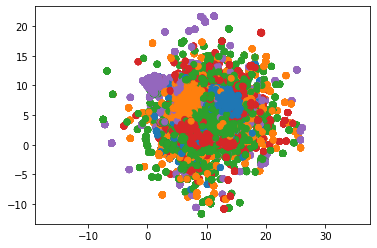

In [29]:
plt.scatter(
    uproj[:, 0],
    uproj[:, 1],
    c=[sns.color_palette()[x] for x in clusters])
plt.gca().set_aspect('equal', 'datalim')

In [10]:
uproj.shape

(2243679, 2)

In [9]:
# clustering
from sklearn.cluster import KMeans, MiniBatchKMeans
km = KMeans(n_clusters=5, init='k-means++', max_iter=800, n_init=20, n_jobs = -1,
                verbose=1)

In [10]:
km.fit(lvars)

/usr/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 1008943.4972915788
Iteration 1, inertia 752200.5652536633
Iteration 2, inertia 736714.0147708786
Iteration 3, inertia 723614.3493134287
Iteration 4, inertia 710869.7258537654
Iteration 5, inertia 703484.4321467892
Iteration 6, inertia 700254.3393807038
Iteration 7, inertia 698603.0662547117
Iteration 8, inertia 697652.1104979872
Iteration 9, inertia 697115.2179589232
Iteration 10, inertia 696815.2127586573
Iteration 11, inertia 696660.146396509
Iteration 12, inertia 696582.3283136414
Iteration 13, inertia 696542.4944458915
Iteration 14, inertia 696522.8306590721
Iteration 15, inertia 696513.1113566222
Iteration 16, inertia 696508.163143893
Iteration 17, inertia 696505.6561966866
Converged at iteration 17: center shift 1.8914217437748041e-06 within tolerance 2.722195487883506e-06
Initialization complete
Iteration 0, inertia 979807.3324228748
Iteration 1, inertia 726421.6003306352
Iteration 2, inertia 706621.1825155978
Iteration 3, inertia 700

KMeans(max_iter=800, n_clusters=5, n_init=20, n_jobs=5, verbose=1)

In [11]:
clusters = km.predict(lvars)

In [12]:
clusters

array([1, 1, 1, ..., 0, 2, 2], dtype=int32)

In [48]:
storyt = pd.DataFrame(stories_aug)

In [49]:
storyt['Topic'] = clusters

In [50]:
storyt

,0,Topic
0,How to Not Mess Up Your Tech Startup kristin...,1
2,Someday you may ditch your two-factor authenti...,1
4,Will State.com become the world's opinion for...,1
5,LightUp Teaches Kids Electronics With Augmente...,1
6,Getting Things Done: Why GTD for Sales is the ...,1
...,...,...
2344431,Italy Follows France in Levying a Digital Tax ...,2
2344432,Amazon is looking into tech that can identify ...,1
2344433,Giant Concentric Circles in Granite Springs Va...,0
2344434,Wyze Data leak 12-26-2019 wyzecam,2


In [26]:
# use tf-idf to extract key words for each topic
# need to do some preprocessing
# use spacy for the job

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
spacy_stopwords = nlp.Defaults.stop_words

In [1]:
import unicodedata

In [16]:
# define function to remove puncts, lemmatize, make lower cased, and tokenize the text
import re
def preprocess(text):
    text = text.apply(lambda x: re.sub(r'[^\u0000-\u007f]', '', x))
    trs = text.apply(lambda x: re.sub("[^a-zA-Z0-9]+", ' ', x))
    ptexts = trs.apply(lambda x: [token.lemma_ for token in nlp(x.lower()) if not token.text in spacy_stopwords and not token.is_punct])
    return ptexts

In [11]:
from multiprocessing import  Pool
from functools import partial
import numpy as np

In [12]:
def mtp(df,efunc,nj=24):
    text_split = np.array_split(df, nj)
    pool = Pool(nj)
    fd = pd.concat(pool.map(efunc, text_split))
    pool.close()
    pool.join()
    return fd

In [17]:
p_stories = mtp(stories_aug, preprocess)

In [18]:
pickle.dump( p_stories, open( "clean_stories.p", "wb" ) )

In [2]:
p_stories =  pickle.load( open( "clean_stories.p", "rb" ) )

In [4]:
# use sklearn tf-idf to determine topic keywords
from sklearn.feature_extraction.text import TfidfVectorizer

In [104]:
p_stories

0                      [mess, tech, startup, kristinabjoran]
2          [someday, ditch, factor, authenticator, electr...
4          [ , state, com, world, s, opinion, forum, pand...
5          [lightup, teach, kid, electronic, augment, rea...
6                [get, thing, gtd, sale, answer, voltagecrm]
                                 ...                        
2344431     [italy, follow, france, levy, digital, tax, wsj]
2344432    [amazon, look, tech, identify, vein, hand, usa...
2344433    [giant, concentric, circle, granite, springs, ...
2344434            [wyze, data, leak, 12, 26, 2019, wyzecam]
2344435    [4, m, card, 4k, drawer, coalition, book, love...
Length: 2243679, dtype: object

In [32]:
import functools
import operator

In [106]:
flatt = []

In [107]:
for i in range(0,5):
    tidx = storyt[storyt.Topic == i].index.values
    tst = p_stories[tidx]
    tstf = functools.reduce(operator.iconcat, tst, [])
    flatt.append(tstf)

In [108]:
tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)

In [109]:
vectors = tfidf.fit_transform(flatt)

In [110]:
names = tfidf.get_feature_names()
data = vectors.todense().tolist()

In [111]:
df = pd.DataFrame(data, columns=names)

In [113]:
for i in df.iterrows():
    print(i[1].sort_values(ascending=False)[:20])

medium      0.429813
s           0.382579
new         0.173278
pdf         0.157410
datum       0.119480
world       0.117376
learn       0.116860
machine     0.104141
nytime      0.102368
human       0.096955
design      0.095115
build       0.091727
learning    0.091450
time        0.089226
future      0.088909
science     0.087823
work        0.087281
bbc         0.086222
system      0.082900
ai          0.080359
Name: 0, dtype: float64
s            0.559779
medium       0.280005
youtube      0.256054
t            0.181813
hn           0.167435
google       0.131459
new          0.127603
github       0.122186
good         0.121974
             0.118479
video        0.111559
nytime       0.094267
startup      0.091858
app          0.090685
blogspot     0.089711
wikipedia    0.085874
facebook     0.082335
world        0.078254
learn        0.074628
time         0.073299
Name: 1, dtype: float64
s              0.586191
new            0.193302
google         0.192008
m              0.159